## Tutorial: Recurrent neural networks for cognitive neuroscience

Creator: Guangyu Robert Yang

Contributors: Jenelle J Feather, Mahdi Fouad Ramadan, Ling Liang Dong, Fernanda De la Torre, Andrew Fracl, Prashant Raju, Ajani Stewart, Eli Pollock, Yoni Friedman, Aniekan Umoren


Note: This tutorial can be used as a standalone tutorial for yourself. It is prepared for a 2h interactive session at MIT BCS.



![Screen%20Shot%202021-08-11%20at%206.44.38%20PM.png](attachment:Screen%20Shot%202021-08-11%20at%206.44.38%20PM.png)

![Screen%20Shot%202021-08-11%20at%206.46.43%20PM.png](attachment:Screen%20Shot%202021-08-11%20at%206.46.43%20PM.png)

![Screen%20Shot%202021-08-11%20at%206.48.10%20PM.png](attachment:Screen%20Shot%202021-08-11%20at%206.48.10%20PM.png)

For more details, you can check out [this talk](https://www.youtube.com/watch?v=Eq-chOIbOwM) or this [Primer](https://www.sciencedirect.com/science/article/abs/pii/S0896627320307054) (its [arxiv version](https://arxiv.org/abs/2006.01001)).

A seminal paper in this area that is a must-read is [Mante\*, Sussillo\*, Shenoy, Newsome 2013](https://www.nature.com/articles/nature12742).

### Installing and importing relevant packages

In [1]:
# # If on Google Colab, uncomment to install neurogym to use cognitive tasks
# ! git clone https://github.com/neurogym/neurogym.git
# %cd neurogym/
# ! pip install -e .

In [1]:
# Import common packages
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

In [2]:
np.__version__

'1.19.5'

### Defining a recurrent neural network

**LSTM**: A typical recurrent network in machine learning. Usage example adopted from pytorch documentation.

In [3]:
import torch
import torch.nn as nn  # nn stands for neural network


# Make a LSTM, input_size is the dimension of inputs,
# hidden_size is the number of hidden neurons
rnn = nn.LSTM(input_size=10, hidden_size=20, num_layers=2)

# Generate some mock inputs
input = torch.randn(5, 3, 10)  # (Sequence Length, Batch Size, Input Size)
output, (hn, cn) = rnn(input)

print('Output shape is (SeqLen, BatchSize, HiddenSize):', output.shape)

Output shape is (SeqLen, BatchSize, HiddenSize): torch.Size([5, 3, 20])


In general, recurrent neural networks transform **sequence to sequence**. Other network architectures, such as MultiHeadAttetion as used in Transformers, can also be thought of as sequence to sequence.

In the context of cognitive neuroscience, the sequence is usually a time series of task input or output.

In [4]:
input = torch.randn(5, 3, 10)  # (Sequence Length, Batch Size, Input Size)

lstm = nn.LSTM(input_size=10, hidden_size=20, num_layers=2)
output, _ = lstm(input)
print('Output shape is (SeqLen, BatchSize, Dimension):', output.shape)

rnn = nn.RNN(input_size=10, hidden_size=20, num_layers=2)
output, _ = rnn(input)
print('Output shape is (SeqLen, BatchSize, Dimension):', output.shape)

gru = nn.GRU(input_size=10, hidden_size=20, num_layers=2)
output, _ = gru(input)
print('Output shape is (SeqLen, BatchSize, Dimension):', output.shape)

mha = nn.MultiheadAttention(embed_dim=10, num_heads=1)
output, _ = mha(query=input, key=input, value=input)
print('Output shape is (SeqLen, BatchSize, Dimension):', output.shape)

Output shape is (SeqLen, BatchSize, Dimension): torch.Size([5, 3, 20])
Output shape is (SeqLen, BatchSize, Dimension): torch.Size([5, 3, 20])
Output shape is (SeqLen, BatchSize, Dimension): torch.Size([5, 3, 20])
Output shape is (SeqLen, BatchSize, Dimension): torch.Size([5, 3, 10])


Some neuroscientists prefer **continuous-time recurrent neural networks**.

Here we first define a continuous-time neural network,
\begin{align}
    \tau \frac{d\mathbf{r}}{dt} = -\mathbf{r}(t) + f(W_r \mathbf{r}(t) + W_x \mathbf{x}(t) + \mathbf{b}_r).
\end{align}

Then we discretize this network in time using the Euler method with a time step of $\Delta t$,
\begin{align}
    \mathbf{r}(t+\Delta t) = \mathbf{r}(t) + \Delta \mathbf{r} &= \mathbf{r}(t) + \frac{\Delta t}{\tau}[-\mathbf{r}(t) + f(W_r \mathbf{r}(t) + W_x \mathbf{x}(t) + \mathbf{b}_r)] \\
    &= (1 - \frac{\Delta t}{\tau})\mathbf{r}(t) + \frac{\Delta t}{\tau}f(W_r \mathbf{r}(t) + W_x \mathbf{x}(t) + \mathbf{b}_r)
\end{align}

In [5]:
# Define networks
import torch
import torch.nn as nn
from torch.nn import init
from torch.nn import functional as F
import math


class CTRNN(nn.Module):
    """Continuous-time RNN.

    Parameters:
        input_size: Number of input neurons
        hidden_size: Number of hidden neurons
        dt: discretization time step in ms.
            If None, dt equals time constant tau

    Inputs:
        input: tensor of shape (seq_len, batch, input_size)
        hidden: tensor of shape (batch, hidden_size), initial hidden activity
            if None, hidden is initialized through self.init_hidden()

    Outputs:
        output: tensor of shape (seq_len, batch, hidden_size)
        hidden: tensor of shape (batch, hidden_size), final hidden activity
    """

    def __init__(self, input_size, hidden_size, dt=None, **kwargs):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.tau = 100
        if dt is None:
            alpha = 1
        else:
            alpha = dt / self.tau
        self.alpha = alpha

        self.input2h = nn.Linear(input_size, hidden_size)
        self.h2h = nn.Linear(hidden_size, hidden_size)

    def init_hidden(self, input_shape):
        batch_size = input_shape[1]
        return torch.zeros(batch_size, self.hidden_size)

    def recurrence(self, input, hidden):
        """Run network for one time step.

        Inputs:
            input: tensor of shape (batch, input_size)
            hidden: tensor of shape (batch, hidden_size)

        Outputs:
            h_new: tensor of shape (batch, hidden_size),
                network activity at the next time step
        """
        h_new = torch.relu(self.input2h(input) + self.h2h(hidden))
        h_new = hidden * (1 - self.alpha) + h_new * self.alpha
        return h_new

    def forward(self, input, hidden=None):
        """Propogate input through the network."""

        # If hidden activity is not provided, initialize it
        if hidden is None:
            hidden = self.init_hidden(input.shape).to(input.device)

        # Loop through time
        output = []
        steps = range(input.size(0))
        for i in steps:
            hidden = self.recurrence(input[i], hidden)
            output.append(hidden)

        # Stack together output from all time steps
        output = torch.stack(output, dim=0)  # (seq_len, batch, hidden_size)
        return output, hidden


class RNNNet(nn.Module):
    """Recurrent network model.

    Parameters:
        input_size: int, input size
        hidden_size: int, hidden size
        output_size: int, output size

    Inputs:
        x: tensor of shape (Seq Len, Batch, Input size)

    Outputs:
        out: tensor of shape (Seq Len, Batch, Output size)
        rnn_output: tensor of shape (Seq Len, Batch, Hidden size)
    """
    def __init__(self, input_size, hidden_size, output_size, **kwargs):
        super().__init__()

        # Continuous time RNN
        self.rnn = CTRNN(input_size, hidden_size, **kwargs)

        # Add an output layer
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        rnn_output, _ = self.rnn(x)
        out = self.fc(rnn_output)
        return out, rnn_output

Similar to LSTM, CTRNN transform sequence to sequence

In [6]:
batch_size = 16
seq_len = 20  # sequence length
input_size = 5  # input dimension

# Make some random inputs
input_rnn = torch.rand(seq_len, batch_size, input_size)

# Make network
rnn = RNNNet(input_size=input_size, hidden_size=100, output_size=10)

# Run the sequence through the network
out, rnn_output = rnn(input_rnn)

print('Input of shape (SeqLen, BatchSize, InputDim)=', input_rnn.shape)
print('Output of shape (SeqLen, BatchSize, Neuron)=', out.shape)

Input of shape (SeqLen, BatchSize, InputDim)= torch.Size([20, 16, 5])
Output of shape (SeqLen, BatchSize, Neuron)= torch.Size([20, 16, 10])


### Defining a simple cognitive task

Here we use the neurogym package to make a simple "perceptual decision making" task.

In [7]:
import gym  # package for RL environments
import neurogym as ngym

# Canned environment from neurogym
task_name = 'PerceptualDecisionMaking-v0'
# Importantly, we set discretization time step for the task as well
kwargs = {'dt': 20, 'timing': {'stimulus': 1000}}

# Boilerplate gym
env = gym.make(task_name, **kwargs)

(**Skip to Visualize Environment if first time reading**) If you prefer, you can copy the [source code](https://github.com/neurogym/neurogym/blob/master/neurogym/envs/perceptualdecisionmaking.py) of this task from neurogym, and customize it. You can create an environment directly from the source code.

In [8]:
from neurogym import spaces

class PerceptualDecisionMaking(ngym.TrialEnv):
    """Two-alternative forced choice task in which the subject has to
    integrate two stimuli to decide which one is higher on average.
    A noisy stimulus is shown during the stimulus period. The strength (
    coherence) of the stimulus is randomly sampled every trial. Because the
    stimulus is noisy, the agent is encouraged to integrate the stimulus
    over time.
    Args:
        cohs: list of float, coherence levels controlling the difficulty of
            the task
        sigma: float, input noise level
        dim_ring: int, dimension of ring input and output
    """
    metadata = {
        'paper_link': 'https://www.jneurosci.org/content/12/12/4745',
        'paper_name': '''The analysis of visual motion: a comparison of
        neuronal and psychophysical performance''',
        'tags': ['perceptual', 'two-alternative', 'supervised']
    }

    def __init__(self, dt=100, rewards=None, timing=None, cohs=None,
                 sigma=1.0, dim_ring=2):
        super().__init__(dt=dt)
        if cohs is None:
            self.cohs = np.array([0, 6.4, 12.8, 25.6, 51.2])
        else:
            self.cohs = cohs
        self.sigma = sigma / np.sqrt(self.dt)  # Input noise

        # Rewards
        self.rewards = {'abort': -0.1, 'correct': +1., 'fail': 0.}
        if rewards:
            self.rewards.update(rewards)

        self.timing = {
            'fixation': 100,
            'stimulus': 2000,
            'delay': 0,
            'decision': 100}
        if timing:
            self.timing.update(timing)

        self.abort = False

        self.theta = np.linspace(0, 2*np.pi, dim_ring+1)[:-1]
        self.choices = np.arange(dim_ring)

        name = {'fixation': 0, 'stimulus': range(1, dim_ring+1)}
        self.observation_space = spaces.Box(
            -np.inf, np.inf, shape=(1+dim_ring,), dtype=np.float32, name=name)
        name = {'fixation': 0, 'choice': range(1, dim_ring+1)}
        self.action_space = spaces.Discrete(1+dim_ring, name=name)

    def _new_trial(self, **kwargs):
        """
        new_trial() is called when a trial ends to generate the next trial.
        The following variables are created:
            durations, which stores the duration of the different periods (in
            the case of perceptualDecisionMaking: fixation, stimulus and
            decision periods)
            ground truth: correct response for the trial
            coh: stimulus coherence (evidence) for the trial
            obs: observation
        """
        # Trial info
        trial = {
            'ground_truth': self.rng.choice(self.choices),
            'coh': self.rng.choice(self.cohs),
        }
        trial.update(kwargs)

        coh = trial['coh']
        ground_truth = trial['ground_truth']
        stim_theta = self.theta[ground_truth]

        # Periods
        self.add_period(['fixation', 'stimulus', 'delay', 'decision'])

        # Observations
        self.add_ob(1, period=['fixation', 'stimulus', 'delay'], where='fixation')
        stim = np.cos(self.theta - stim_theta) * (coh/200) + 0.5
        self.add_ob(stim, 'stimulus', where='stimulus')
        self.add_randn(0, self.sigma, 'stimulus', where='stimulus')

        # Ground truth
        self.set_groundtruth(ground_truth, period='decision', where='choice')

        return trial

    def _step(self, action):
        """
        _step receives an action and returns:
            a new observation, obs
            reward associated with the action, reward
            a boolean variable indicating whether the experiment has end, done
            a dictionary with extra information:
                ground truth correct response, info['gt']
                boolean indicating the end of the trial, info['new_trial']
        """
        new_trial = False
        # rewards
        reward = 0
        gt = self.gt_now
        # observations
        if self.in_period('fixation'):
            if action != 0:  # action = 0 means fixating
                new_trial = self.abort
                reward += self.rewards['abort']
        elif self.in_period('decision'):
            if action != 0:
                new_trial = True
                if action == gt:
                    reward += self.rewards['correct']
                    self.performance = 1
                else:
                    reward += self.rewards['fail']

        return self.ob_now, reward, False, {'new_trial': new_trial, 'gt': gt}

# Create environment from source code
env2 = PerceptualDecisionMaking(**kwargs)

**Visualize the environment.**

The following function helps us visualize the environment. It shows from top
1. observation that the network/agent receives,
2. actions taken by a random agent and the ground-truth (when applicable),
3. reward received by the agent (relevant for reinforcement learning),
4. performance of the network (we'll re-compute this explicitly ourselves).

/home/abuzarmahmood/anaconda3/envs/pytorch_env/lib/python3.8/site-packages/gym/utils/passive_env_checker.py:195: UserWarning: WARN: The result returned by `env.reset()` was not a tuple of the form `(obs, info)`, where `obs` is a observation and `info` is a dictionary containing additional information. Actual type: `<class 'numpy.ndarray'>`
  logger.warn(
/home/abuzarmahmood/anaconda3/envs/pytorch_env/lib/python3.8/site-packages/gym/utils/passive_env_checker.py:219: DeprecationWarning: WARN: Core environment is written in old step API which returns one bool instead of two. It is recommended to rewrite the environment with new step API. 
  logger.deprecation(
findfont: Font family ['arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['arial'] not found. Falling back to DejaVu Sans.


Input size 3
Output size 3


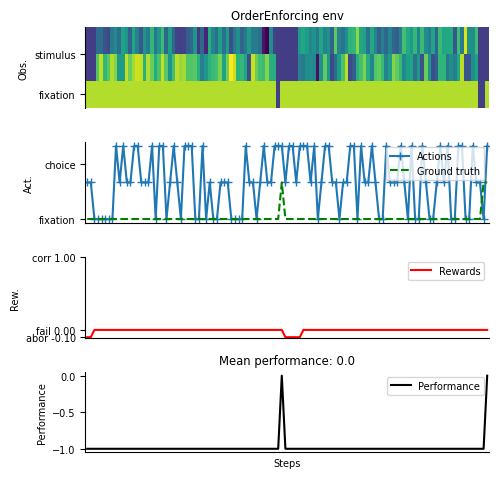

In [9]:
# Visualize the environment with 2 sample trials
_ = ngym.utils.plot_env(env, num_trials=2)

# This is a simple task, the input and output are low-dimensional
input_size = env.observation_space.shape[0]
output_size = env.action_space.n
print('Input size', input_size)
print('Output size', output_size)

For **supervised learning**, we need a dataset that returns (input, target output pairs).

In [10]:
# Make supervised dataset, neurogym boilerplate
seq_len = 100
batch_size = 16
dataset = ngym.Dataset(env, batch_size=batch_size, seq_len=seq_len)

# Generate one batch of data when called
inputs, target = dataset()
print('Input has shape (SeqLen, Batch, Dim) =', inputs.shape)
print('Target has shape (SeqLen, Batch) =', target.shape)
print('Target are the integers, for example target in the first sequence:')
print(target[:, 0])

Input has shape (SeqLen, Batch, Dim) = (100, 16, 3)
Target has shape (SeqLen, Batch) = (100, 16)
Target are the integers, for example target in the first sequence:
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


### Training the network to perform the task

In [11]:
import torch.optim as optim
import time

# Instantiate the network and print information
hidden_size = 128
net = RNNNet(input_size=input_size, hidden_size=hidden_size,
             output_size=output_size, dt=env.dt)
print(net)

def train_model(net, dataset):
    """Simple helper function to train the model.

    Args:
        net: a pytorch nn.Module module
        dataset: a dataset object that when called produce a (input, target output) pair

    Returns:
        net: network object after training
    """
    # Use Adam optimizer
    optimizer = optim.Adam(net.parameters(), lr=0.01)
    criterion = nn.CrossEntropyLoss()

    running_loss = 0
    running_acc = 0
    start_time = time.time()
    # Loop over training batches
    print('Training network...')
    for i in range(1000):
        # Generate input and target, convert to pytorch tensor
        inputs, labels = dataset()
        inputs = torch.from_numpy(inputs).type(torch.float)
        labels = torch.from_numpy(labels.flatten()).type(torch.long)

        # boiler plate pytorch training:
        optimizer.zero_grad()   # zero the gradient buffers
        output, _ = net(inputs)
        # Reshape to (SeqLen x Batch, OutputSize)
        output = output.view(-1, output_size)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()    # Does the update

        # Compute the running loss every 100 steps
        running_loss += loss.item()
        if i % 100 == 99:
            running_loss /= 100
            print('Step {}, Loss {:0.4f}, Time {:0.1f}s'.format(
                i+1, running_loss, time.time() - start_time))
            running_loss = 0
    return net

net = train_model(net, dataset)

RNNNet(
  (rnn): CTRNN(
    (input2h): Linear(in_features=3, out_features=128, bias=True)
    (h2h): Linear(in_features=128, out_features=128, bias=True)
  )
  (fc): Linear(in_features=128, out_features=3, bias=True)
)
Training network...
Step 100, Loss 0.1917, Time 3.3s
Step 200, Loss 0.0671, Time 6.6s
Step 300, Loss 0.0536, Time 9.9s
Step 400, Loss 0.0437, Time 13.2s
Step 500, Loss 0.3045, Time 16.5s
Step 600, Loss 0.0586, Time 19.7s
Step 700, Loss 0.0432, Time 22.9s
Step 800, Loss 0.0373, Time 26.1s
Step 900, Loss 0.0324, Time 29.5s
Step 1000, Loss 0.0354, Time 32.9s


### Run the network after training, record activity, compute performance

Here we run the network after training. We could have used similar functions as we did in the `train_model` function. But instead we will explicitly loop through individual trials, so we can log the information and compute the performance of each trial.

In [12]:
import numpy as np
# Reset environment
env = dataset.env
env.reset(no_step=True)

# Initialize variables for logging
perf = 0
activity_dict = {}  # recording activity
trial_infos = {}  # recording trial information

num_trial = 200
for i in range(num_trial):
    # Neurogym boiler plate
    # Sample a new trial
    trial_info = env.new_trial()
    # Observation and groud-truth of this trial
    ob, gt = env.ob, env.gt
    # Convert to numpy, add batch dimension to input
    inputs = torch.from_numpy(ob[:, np.newaxis, :]).type(torch.float)

    # Run the network for one trial
    # inputs (SeqLen, Batch, InputSize)
    # action_pred (SeqLen, Batch, OutputSize)
    action_pred, rnn_activity = net(inputs)

    # Compute performance
    # First convert back to numpy
    action_pred = action_pred.detach().numpy()[:, 0, :]
    # Read out final choice at last time step
    choice = np.argmax(action_pred[-1, :])
    # Compare to ground truth
    correct = choice == gt[-1]

    # Record activity, trial information, choice, correctness
    rnn_activity = rnn_activity[:, 0, :].detach().numpy()
    activity_dict[i] = rnn_activity
    trial_infos[i] = trial_info  # trial_info is a dictionary
    trial_infos[i].update({'correct': correct})

# Print informations for sample trials
for i in range(5):
    print('Trial ', i, trial_infos[i])

print('Average performance', np.mean([val['correct'] for val in trial_infos.values()]))

Trial  0 {'ground_truth': 0, 'coh': 0.0, 'correct': True}
Trial  1 {'ground_truth': 1, 'coh': 12.8, 'correct': True}
Trial  2 {'ground_truth': 0, 'coh': 6.4, 'correct': True}
Trial  3 {'ground_truth': 1, 'coh': 51.2, 'correct': True}
Trial  4 {'ground_truth': 1, 'coh': 25.6, 'correct': True}
Average performance 0.825


### Plot the network's activity in PCA

Next we will analyze the network by plotting its activity in PCA space. Each trajectory in the PC-space would correspond to a single trial.

In [13]:
# Apply PCA, boilerplate sklearn
from sklearn.decomposition import PCA

# Concatenate activity for PCA
activity = np.concatenate(list(activity_dict[i] for i in range(num_trial)), axis=0)
print('Shape of the neural activity: (Time points, Neurons): ', activity.shape)

pca = PCA(n_components=2)
pca.fit(activity)  # activity (Time points, Neurons)
activity_pc = pca.transform(activity)  # transform to low-dimension
print('Shape of the projected activity: (Time points, PCs): ', activity_pc.shape)

Shape of the neural activity: (Time points, Neurons):  (12000, 128)
Shape of the projected activity: (Time points, PCs):  (12000, 2)


Text(0, 0.5, 'PC 2')

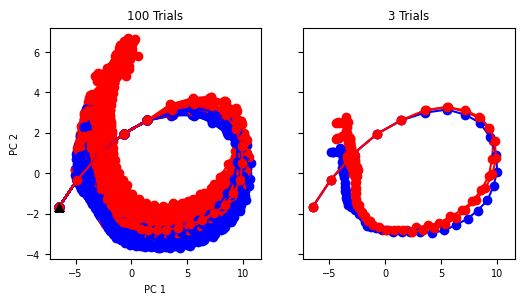

In [14]:
# Project each trial and visualize activity

import matplotlib.pyplot as plt

# Plot all trials in ax1, plot fewer trials in ax2
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, sharex=True, figsize=(6, 3))

for i in range(100):
    # Transform and plot each trial
    activity_pc = pca.transform(activity_dict[i])  # (Time points, PCs)

    trial = trial_infos[i]
    color = 'red' if trial['ground_truth'] == 0 else 'blue'

    _ = ax1.plot(activity_pc[:, 0], activity_pc[:, 1], 'o-', color=color)
    if i < 3:
        _ = ax2.plot(activity_pc[:,
                                 0], activity_pc[:, 1], 'o-', color=color)

    # Plot the beginning of a trial with a special symbol
    _ = ax1.plot(activity_pc[0, 0], activity_pc[0, 1], '^', color='black')

ax1.set_title('{:d} Trials'.format(100))
ax2.set_title('{:d} Trials'.format(3))
ax1.set_xlabel('PC 1')
ax1.set_ylabel('PC 2')

### Exercises

In the following section, we have 9 exercises, separated into 3 categories: Easy, Medium, Hard.

Ideally, each exercise should take no more than 1 hour. If you are spending a long time on one exercise, consider choosing one that is easier.

### Exercise 1: Time constant of RNNs

**Easy** | Medium | Hard

Change the time constant of network units from 100ms to 40ms, and re-train the network. How does the final performance change?

What about changing the discretization time step from 20ms to 10ms, while keeping the time constant at 100ms?

In [17]:
kwargs = {'dt': 20, 'timing': {'stimulus': 1000}}

# Boilerplate gym
env = gym.make(task_name, **kwargs)
dataset = ngym.Dataset(env, batch_size=batch_size, seq_len=seq_len)
# Generate one batch of data when called
inputs, target = dataset()
input_size = env.observation_space.shape[0]
output_size = env.action_space.n

net = RNNNet(input_size=input_size, hidden_size=hidden_size,
             output_size=output_size, tau = 40, dt=env.dt)
print(net)

trial_infos, activity_dict = test_model(net, env, num_trial = 1000)
print('Average performance pre-training', np.mean([val['correct'] for val in trial_infos.values()]))

net = train_model(net, dataset)

trial_infos, activity_dict = test_model(net, env, num_trial = 1000)
print('Average performance post-training', np.mean([val['correct'] for val in trial_infos.values()]))

RNNNet(
  (rnn): CTRNN(
    (input2h): Linear(in_features=3, out_features=128, bias=True)
    (h2h): Linear(in_features=128, out_features=128, bias=True)
  )
  (fc): Linear(in_features=128, out_features=3, bias=True)
)


TypeError: forward() got an unexpected keyword argument 'num_trial'

In [ ]:
kwargs = {'dt': 40, 'timing': {'stimulus': 1000}}

# Boilerplate gym
env = gym.make(task_name, **kwargs)
dataset = ngym.Dataset(env, batch_size=batch_size, seq_len=seq_len)
# Generate one batch of data when called
inputs, target = dataset()
input_size = env.observation_space.shape[0]
output_size = env.action_space.n

net = RNNNet(input_size=input_size, hidden_size=hidden_size,
             output_size=output_size, tau = 100, dt=env.dt)
print(net)

trial_infos, activity_dict = test_model(net, env, num_trial = 1000)
print('Average performance pre-training', np.mean([val['correct'] for val in trial_infos.values()]))

net = train_model(net, dataset)

trial_infos, activity_dict = test_model(net, env, num_trial = 1000)
print('Average performance post-training', np.mean([val['correct'] for val in trial_infos.values()]))

### Exercise 2: Plot the performance of RNN during training

**Easy** | Medium | Hard

Plot the performance of the task during the training process. Generate a plot with x-axis training steps, and y-axis performance.

Hint: You can re-use the performance computing code from above.

RNNNet(
  (rnn): CTRNN(
    (input2h): Linear(in_features=3, out_features=64, bias=True)
    (h2h): Linear(in_features=64, out_features=64, bias=True)
  )
  (fc): Linear(in_features=64, out_features=3, bias=True)
)
Training network...
Step 100, Loss 0.3112, Acc 0.9187
Step 200, Loss 0.1715, Acc 0.9293
Step 300, Loss 0.1158, Acc 0.9512
Step 400, Loss 0.0935, Acc 0.9554
Step 500, Loss 0.0806, Acc 0.9596
Step 600, Loss 0.0933, Acc 0.9580
Step 700, Loss 0.1190, Acc 0.9588
Step 800, Loss 0.1864, Acc 0.9563
Step 900, Loss 0.2816, Acc 0.9502
Step 1000, Loss 0.5663, Acc 0.9362


Text(0.5, 1.0, 'Accuracies')

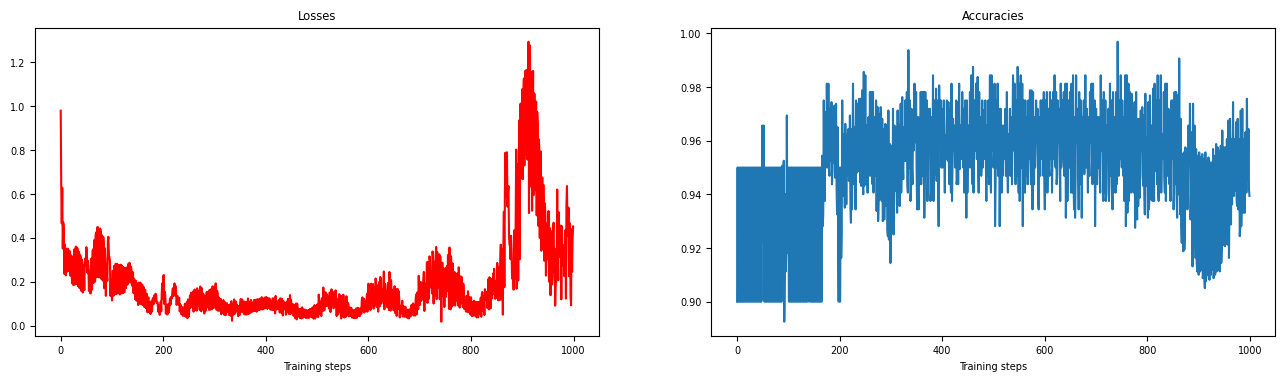

In [21]:
# Instantiate the network and print information
hidden_size = 64
net = RNNNet(input_size=input_size, hidden_size=hidden_size,
             output_size=output_size, dt=env.dt)
print(net)

def train_model(net, dataset):
    """Simple helper function to train the model.

    Args:
        net: a pytorch nn.Module module
        dataset: a dataset object that when called produce a (input, target output) pair

    Returns:
        net: network object after training
    """
    # Use Adam optimizer
    optimizer = optim.Adam(net.parameters(), lr=0.01)
    criterion = nn.CrossEntropyLoss()

    running_loss = 0
    running_acc = 0

	############################################################
	# arrays to store all the losses / performance accuracy
	############################################################
    losses = []
    accuracies = []

    # Loop over training batches
    print('Training network...')
    for i in range(1000):
        # Generate input and target, convert to pytorch tensor
        inputs, labels = dataset()
        inputs = torch.from_numpy(inputs).type(torch.float)
        labels = torch.from_numpy(labels.flatten()).type(torch.long)

        # boiler plate pytorch training:
        #optimizer.zero_grad()   # zero the gradient buffers
        output, _ = net(inputs)
        output = output.view(-1, output_size)


        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()    # Does the update

    	#####################################################################
        # Compute accuracy by comparing model choices to ground truth labels
    	# and store both the accuracy and loss
		###########################################################################
        choices = torch.argmax(output, dim=1)
        acc = torch.mean(torch.eq(choices, labels).type(torch.float32))

        running_acc += acc.item()
        running_loss += loss.item()

        accuracies.append(acc.item())
        losses.append(loss.item())

        # Compute the running loss every 100 steps
        if i % 100 == 99:
            running_loss /= 100
            running_acc /= 100
            print('Step {}, Loss {:0.4f}, Acc {:0.4f}'.format(i+1, running_loss, running_acc))
            running_acc = 0
            running_loss = 0

    return net, accuracies, losses

net, accuracies, losses = train_model(net, dataset)


########################
# Plot the performance
########################

fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True, figsize=(16, 4))
ax1.plot(losses, color="red")
ax2.plot(accuracies)

ax1.set_xlabel("Training steps")
ax2.set_xlabel("Training steps")

ax1.set_title("Losses")
ax2.set_title("Accuracies")

### Exercise 3: Change the initialization of the RNN

**Easy** | Medium | Hard

Right now the RNN is initialized with the default pytorch initialization. Set instead the initial recurrent weight to an identity matrix. How does that influence the final performance?

Hint: You can plot the current initialization of the recurrent weight using the following code block.

In [ ]:
# Make network
rnn = CTRNN(input_size=3, hidden_size=100)
print('Shape of RNN recurrent weight is ', rnn.h2h.weight.shape)

# Convert pytorch tensor to numpy array, pytorch boilerplate
weight = rnn.h2h.weight.detach().numpy()

plt.imshow(weight)
plt.title('RNN weight at initialization')

In [ ]:
# First, create a function that takes care of plotting the weight matrix:
def show_weight(net):
  weight = net.rnn.h2h.weight.detach().numpy()

  plt.imshow(weight)
  plt.title('RNN weight at initialization')
  plt.show()

# Next, run the training as before, showing the weight matrix before and after,
# with random initialization. This gives a baseline for comparison
net = RNNNet(input_size=input_size, hidden_size=hidden_size,
             output_size=output_size, dt=env.dt)
show_weight(net)
net = train_model(net, dataset)
show_weight(net)

# Finally, we want to set the initial weights equal to the identity matrix.
# To do this, we can use the torch.eye() function to create an identity matrix,
# specifying that it is of the correct size. We have to pass this through nn.Parameter
# to ensure that it can be used in an rnn object. We can then just set the
# h2h (hidden to hidden) weight matrix to be equal to this.

# I have also included a parameter "alpha" that can be used to scale the
# initial identity matrix. The following code shows the weight matrix before
# and after training, as before.

alpha = 0.1  # Values of around 0.01-0.1 work well
net.rnn.h2h.weight = nn.Parameter(alpha*torch.eye(net.rnn.hidden_size))
show_weight(net)
net = train_model(net, dataset)
show_weight(net)

# The results should show that scaled identity matrices can be good
# initializations for the recurrent weights.

# For more about using the identity matrix as the initial weight matrix,
# see Le et al. 2015 (https://arxiv.org/abs/1504.00941)

### Exercise 4: Hierarchical RNNs

Easy | **Medium** | Hard

Make a hierarhical RNN, where the first module receives external input, the second module receives inputs from the first and project to the third module. The third module produces the outputs.

Train this hierarhical RNN on the task.

(Optional) Visualize the activity on each module.

In [ ]:
class HierarchicalRNNnet(nn.Module):
    """Hierarchical recurrent network model.
    Parameters:
        input_size: int, input size
        hidden_size: int, hidden size
        output_size: int, output size
    Inputs:
        x: tensor of shape (Seq Len, Batch, Input size)
    Outputs:
        out: tensor of shape (Seq Len, Batch, Output size)
        rnn_output: tensor of shape (Seq Len, Batch, Hidden size)
    """
    def __init__(self, input_size, hidden_size, output_size, **kwargs):
        super().__init__()
        # Continuous time RNN
        self.rnn1 = CTRNN(input_size, hidden_size, **kwargs)
        self.rnn2 = CTRNN(hidden_size, hidden_size, **kwargs)
        self.rnn3 = CTRNN(hidden_size, hidden_size, **kwargs)
        self.RNN_modules = [self.rnn1, self.rnn2, self.rnn3]
        # Add an output layer
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        hiddens = [module.init_hidden(x.shape).to(x.device) for module in self.RNN_modules]
        output = []
        for i in range(x.size(0)):
            for j in range(len(self.RNN_modules)):
                input = x[i] if j == 0 else hiddens[j - 1]
                hiddens[j] = self.RNN_modules[j].recurrence(input, hiddens[j])
            output.append(hiddens[-1])
        output = torch.stack(output, dim = 0)
        out = self.fc(output)
        return out, output

### Exercise 5: Sequential training of tasks

Easy | **Medium** | Hard

First train the network on one task, then train the network on the second task. Plot the performance of both tasks during the training process (see Exercise 2).

Hint: you can get many tasks with the same input and output format using the yang19 collection in neurogym. Get the name of all tasks by running:

`print(ngym.get_collection('yang19'))`

In [ ]:
rint(ngym.get_collection('yang19'))

# Canned environment from neurogym
task_names = ['yang19.go-v0', 'yang19.rtgo-v0']
# Importantly, we set discretization time step for the task as well
kwargs = {'dt': 20, 'timing': {'stimulus': 1000}}

# Boilerplate gyms
envs = [gym.make(task_name, **kwargs) for task_name in task_names]

# Checking env input/output dimensions
for task_name, env in zip(task_names, envs):
    print(f'Task: {task_name}')
    input_size = env.observation_space.shape[0]
    output_size = env.action_space.n
    print('Input size', input_size)
    print(f'Output size {output_size}\n')


# Instantiate the network and print information
hidden_size = 128
net = RNNNet(input_size=input_size, hidden_size=hidden_size,
             output_size=output_size, dt=env.dt)
print(net)
running_losses = {}
losses = {}
# Training on task 0 then 1
for task_name, env in zip(task_names, envs):
    # Make supervised dataset, neurogym boilerplate
    seq_len = 100
    batch_size = 16
    dataset = ngym.Dataset(env, batch_size=batch_size, seq_len=seq_len)
    net, r_losses, _ = train_model(net, dataset, return_losses=True)
    running_losses[task_name] = r_losses


In [ ]:
# Training only on task 1
net = RNNNet(input_size=input_size, hidden_size=hidden_size,
             output_size=output_size, dt=env.dt)
dataset = ngym.Dataset(envs[-1], batch_size=batch_size, seq_len=seq_len)
net, running_losses_no_pretrain, _ = train_model(net, dataset, return_losses=True)

# Plotting
for task_name in task_names:
    plt.plot(running_losses[task_name])
plt.plot(running_losses_no_pretrain)
lgd = task_names[:]
lgd.append(task_names[-1] + '-only')
plt.legend(lgd)

# Pre-training on 'yang19.go-v0' seems to improve training convergence on 'yang19.rtgo-v0'


### Exercise 6: Training only output connections

Easy | **Medium** | Hard

Train only the output connections of the network, and plot performance. Compare performance with networks that have all weights trained.

In [22]:
# Instantiate the network and print information
hidden_size = 128
net = RNNNet(input_size=input_size, hidden_size=hidden_size,
             output_size=output_size, dt=env.dt)
print(net)

# freeze (make them untrainable) all layers of the network
for param in net.parameters():
  param.requires_grad = False

# replace the output connections so that they are still trainable
net.fc = nn.Linear(hidden_size, output_size)

# train only output connections
net = train_model(net,dataset=dataset)

RNNNet(
  (rnn): CTRNN(
    (input2h): Linear(in_features=3, out_features=128, bias=True)
    (h2h): Linear(in_features=128, out_features=128, bias=True)
  )
  (fc): Linear(in_features=128, out_features=3, bias=True)
)
Training network...
Step 100, Loss 0.7954, Acc 0.8432
Step 200, Loss 2.5967, Acc 0.9233
Step 300, Loss 3.1995, Acc 0.9350
Step 400, Loss 1.9849, Acc 0.9248
Step 500, Loss 2.4729, Acc 0.8508
Step 600, Loss 4.0284, Acc 0.9220
Step 700, Loss 3.9605, Acc 0.9265
Step 800, Loss 2.2136, Acc 0.8100
Step 900, Loss 1.9731, Acc 0.9204
Step 1000, Loss 5.3544, Acc 0.9350


### Exercise 7: Training spatially embedded RNNs

Easy | Medium | **Hard**

In normal neural networks, RNN units have no spatial locations. Assume that the RNN units are embedded in a 2-D cortical sheet, and it is more costly to have long-range connections. Train such spatially embedded RNNs and show that this influences the connectivity structure after training.

Hint: Several functions you want to consider writing:
1. Assigning network units spatial locations
2. Define a (differentiable) loss that depends on the connection weight from one neuron to another and their spatial distance.
3. Add this loss to the the training loss
4. Visualize connectivity matrix with and without the long-distance loss.

In [ ]:

# for visualization
def plot_pca(trial_infos, activity_dict):
    n_trials = len(activity_dict)
    activity = np.concatenate(list(activity_dict[i] for i in range(n_trials)), axis=0)

    pca = PCA(n_components=2)
    pca.fit(activity)

    fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, sharex=True, figsize=(6, 3))
    for i in range(n_trials):
        activity_pc = pca.transform(activity_dict[i])
        trial = trial_infos[i]
        color = 'red' if trial['ground_truth'] == 0 else 'blue'
        _ = ax1.plot(activity_pc[:, 0], activity_pc[:, 1], 'o-', color=color)

        if i < 3:
            _ = ax2.plot(activity_pc[:, 0], activity_pc[:, 1], 'o-', color=color)

    ax1.set_title('{:d} Trials'.format(len(trial_infos)))
    ax2.set_title('{:d} Trials'.format(3))
    ax1.set_xlabel('PC 1')
    ax1.set_ylabel('PC 2')
    return fig, (ax1, ax2)

In [ ]:
# We'll use a hidden size of 64 for better visualization
hidden_size = 64

# Create gym environment
kwargs = {'dt': 20, 'timing': {'stimulus': 1000}}
env = gym.make(task_name, **kwargs)
dataset = ngym.Dataset(env, batch_size=batch_size, seq_len=seq_len)
# Generate one batch of data when called
inputs, target = dataset()
input_size = env.observation_space.shape[0]
output_size = env.action_space.n

net = RNNNet(input_size=input_size, hidden_size=hidden_size,
             output_size=output_size, tau = 100, dt=env.dt)
print(net)

In [ ]:
# We can imagine that the 64 hidden neurons lie on a 8x8 grid
# The following image visualizes the pairwise distances from neuron (0, 0)
w = int(np.sqrt(net.rnn.h2h.weight.data.shape[0]))
X, Y = np.meshgrid(range(w), range(w))

def calculate_distances(x, y, X, Y):
    distances = np.sqrt((x - X) ** 2 + (y - Y) ** 2)
    return distances

def calculate_distance(pos1, pos2):
    x1, y1 = pos1
    x2, y2 = pos2
    return np.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)


distances = calculate_distances(0, 0, X, Y)
plt.imshow(distances)

In [ ]:
# `locs` stores the x, y coordinates for each of the hidden units
locs =  np.array([[i, j] for i in range(w) for j in range(w)])
locs_str = ["%d, %d" % (i, j) for i, j in locs]

# We'll calculate the pairwise distances to other neurons for each of the 64 neurons
rnn_distances = np.zeros(net.rnn.h2h.weight.data.shape)
for i in range(len(locs)):
    rnn_distances[i, :] = np.sqrt((locs[i, 0] - locs[:, 0]) ** 2 + (locs[i, 1] - locs[:, 1]) ** 2)

plt.figure(figsize = (12, 4))
for i in range(8):
    plt.subplot(1, 8, i + 1)
    plt.imshow(rnn_distances[i, :].reshape((w, w)))

plt.figure(figsize = (8, 8))
plt.imshow(rnn_distances)
plt.colorbar()
_ = plt.yticks(np.arange(0, w ** 2), labels = locs_str)
_ = plt.xticks(np.arange(0, w ** 2, w), labels = locs_str[::w])

In [ ]:
# define a new function to train the model, adding a spatial loss
def train_spatial_model(net, dataset, iters = 1000, evaluate = False,
                        rnn_distances = rnn_distances, spatial_coef = 1e-4):
    # Use Adam optimizer
    optimizer = optim.Adam(net.parameters(), lr=0.01)
    criterion = nn.CrossEntropyLoss()
    net.train()

    rnn_distances = torch.tensor(rnn_distances).float()

    training_losses = []
    val_acc = []

    running_loss = 0
    running_acc = 0
    # Loop over training batches
    for i in range(iters):
        # Generate input and target, convert to pytorch tensor
        inputs, labels = dataset()
        inputs = torch.from_numpy(inputs).type(torch.float)
        labels = torch.from_numpy(labels.flatten()).type(torch.long)

        optimizer.zero_grad()   # zero the gradient buffers
        output, _ = net(inputs) # output, rnn_output
        output = output.view(-1, output_size)
        task_loss = criterion(output, labels)
        # Spatial loss
        spatial_loss = spatial_coef * torch.sum(torch.abs(net.rnn.h2h.weight) * rnn_distances)

        loss = task_loss + spatial_loss
        loss.backward()
        optimizer.step()    # Does the update

        # Compute the running loss every 100 steps
        running_loss += loss.item()
        if i % 100 == 0:
            if i != 0:
                running_loss /= 100
            training_losses.append(running_loss)
            print('Step {}, Loss {:0.4f}, last task loss {:.4f}, spatial loss {:.4f}'.format(
                i, running_loss, task_loss, spatial_loss))
            running_loss = 0

            if evaluate:
                trial_infos, activity = test_model(net, dataset.env, num_trial = 100)
                val_acc.append(np.mean([val['correct'] for val in trial_infos.values()]))

    if evaluate:
        plt.figure(figsize = [10, 4])
        plt.subplot(1, 2, 1)
        plt.plot(training_losses, label = "training")
        plt.title("Training Loss")
        plt.subplot(1, 2, 2)
        plt.plot(val_acc, label = "validation")
        plt.title("Validation Accuracy")

    return net

In [ ]:
net = RNNNet(input_size=input_size, dataset = dataset, hidden_size=hidden_size,
             output_size=output_size, dt=env.dt)

plt.imshow(np.abs(net.rnn.h2h.weight.data.numpy()))
plt.colorbar()
plt.title("Recurrent weight (magnitude)")

trial_infos, activity_dict = test_model(net, env, num_trial = 1000)
print('Average performance pre-training', np.mean([val['correct'] for val in trial_infos.values()]))
fig, axes = plot_pca(trial_infos, activity_dict)
_ = plt.suptitle("Pre-training Network Activity")

In [ ]:
# change the spatial coef used in the spatial loss
# to get different recurrent weight results!
net = train_spatial_model(net, dataset = dataset, evaluate = True, spatial_coef = 1e-3)

In [ ]:
plt.imshow(np.abs(net.rnn.h2h.weight.data.numpy()))
plt.colorbar()
plt.title("Recurrent weight magnitudes")

trial_infos, activity_dict = test_model(net, env, num_trial = 1000)
print('Average performance post-training', np.mean([val['correct'] for val in trial_infos.values()]))
fig, axes = plot_pca(trial_infos, activity_dict)
plt.suptitle("Post-training Network Activity")

### Exercise 8: ConvNet + RNN

Easy | Medium | **Hard**

Design your own task or use the following task that provides image input at each time point. Add a convolutional network as the sensory module. No need to train the convolutional network.

Optional: Use a small pre-trained convolutional network.

In [ ]:
# A simple image based decision making task for this tutorial

class SimpleVisualDecisionMaking(ngym.TrialEnv):
    """Two-alternative forced choice task in which the subject has to
    integrate two stimuli to decide whether there is a horizontal or vertical bar.

    During a fixation period, a square is shown without noise. Then during
    the stimulus period, a horizontal or vertical bar is shown with noise. Then during
    the decision period, no stimulus is shown and the network should make a decision.

    Args:
        sigma: float, input noise level
    """

    def __init__(self, dt=100, rewards=None, timing=None, sigma=1.0):
        super().__init__(dt=dt)
        # Rewards
        self.rewards = {'abort': -0.1, 'correct': +1., 'fail': 0.}
        if rewards:
            self.rewards.update(rewards)

        self.timing = {
            'fixation': 100,
            'stimulus': 300,
            'decision': 100}
        if timing:
            self.timing.update(timing)

        self.sigma = sigma

        self.abort = False

        # Box shape (Channel, Height, Width)
        self.ob_shape = (1, 10, 10)
        self.observation_space = spaces.Box(
            -np.inf, np.inf, shape=self.ob_shape, dtype=np.float32)
        name = {'fixation': 0, 'choice': [1, 2]}
        self.action_space = spaces.Discrete(3, name=name)

    def _new_trial(self, **kwargs):
        # Trial info
        trial = {
            'ground_truth': self.rng.choice([0, 1]),
        }
        trial.update(kwargs)

        ground_truth = trial['ground_truth']

        # Periods
        self.add_period(['fixation', 'stimulus', 'decision'])

        # Observations
        im = np.zeros(self.ob_shape)
        im[0, 4:6, 4:6] = 1
        self.add_ob(im, period='fixation')

        im = np.zeros(self.ob_shape)
        if ground_truth == 0:
            im[0, 2:8, 4:6] = 1
        else:
            im[0, 4:6, 2:8] = 1
        self.add_ob(im, period='stimulus')
        self.add_randn(0, self.sigma, period='stimulus')

        # Ground truth
        self.set_groundtruth(ground_truth, period='decision', where='choice')

        return trial

    def _step(self, action):
        """
        _step receives an action and returns:
            a new observation, obs
            reward associated with the action, reward
            a boolean variable indicating whether the experiment has end, done
            a dictionary with extra information:
                ground truth correct response, info['gt']
                boolean indicating the end of the trial, info['new_trial']
        """
        new_trial = False
        # rewards
        reward = 0
        gt = self.gt_now
        # observations
        if self.in_period('fixation'):
            if action != 0:  # action = 0 means fixating
                new_trial = self.abort
                reward += self.rewards['abort']
        elif self.in_period('decision'):
            if action != 0:
                new_trial = True
                if action == gt:
                    reward += self.rewards['correct']
                    self.performance = 1
                else:
                    reward += self.rewards['fail']

        return self.ob_now, reward, False, {'new_trial': new_trial, 'gt': gt}

Visualize the environment

`sigma` adjusts the noise level. If you use `sigma=0`, you will see the horizontal or vertical bar clearly. Set `sigma=1` or higher to challenge the network and require it to use recurrent connections for integration.

In [ ]:
# Create environment from source code
vis_env = SimpleVisualDecisionMaking(dt=50, sigma=0.0)

vis_env.reset(no_step=True)
# Loop through several time steps
for i in range(10):
    ob, _, _, _ = vis_env.step(action=0)  # keep choosing action 0

    plt.figure(figsize=(1.5, 1.5))
    plt.imshow(ob[0])
    plt.title('Time in trial {:d} ms'.format(vis_env.t))
    plt.axis('off')
    plt.show()

In [ ]:
## Set up a single layer CNN to use as the preprocessing for the network

# Try changing the kernel size and the number of units to see how it influences
# performance.

class SimpleSeqConvNetBackbone(nn.Module):
  """Sets up a single layer convolutional network to use as the preprocessing
  for the RNN. Network weights are set to random for this demo."""
  def __init__(self, input_channels, num_units=16, kernel_size=[3,3], **kwargs):
    super().__init__()
    self.conv1 = torch.nn.Conv2d(input_size, num_units, kernel_size)
    self.flatten = torch.nn.Flatten()

  def forward(self, x):
    all_cnn_output = []
    for i in range(x.shape[1]):
      all_cnn_output.append(self.flatten(self.conv1(x[:,i,:,:,:])))
    return torch.stack(all_cnn_output, dim=1)

def train_conv_backbone_model(net, dataset, convnet_backbone):
   """Simple helper function to train the model.

   Args:
       net: a pytorch nn.Module module
       dataset: a dataset object that when called produce a (input, target output) pair
       convnet_backbone : a CNN backbone to run the inpt through before going to the RNN

   Returns:
       net: network object after training
   """
   # Use Adam optimizer
   optimizer = optim.Adam(net.parameters(), lr=0.01)
   criterion = nn.CrossEntropyLoss()

   running_loss = 0
   running_acc = 0
   start_time = time.time()
   # Loop over training batches
   print('Training network...')
   for i in range(1000):
       # Generate input and target, convert to pytorch tensor
       inputs, labels = dataset()
       inputs = torch.from_numpy(inputs).type(torch.float)
       labels = torch.from_numpy(labels.flatten()).type(torch.long)

       # Run the input through the convnet to extract activations
       inputs = convnet_backbone(inputs)

       # boiler plate pytorch training:
       optimizer.zero_grad()   # zero the gradient buffers
       output, _ = net(inputs)
       # Reshape to (SeqLen x Batch, OutputSize)
       output = output.view(-1, output_size)
       loss = criterion(output, labels)
       loss.backward()
       optimizer.step()    # Does the update

       # Compute the running loss every 100 steps
       running_loss += loss.item()
       if i % 100 == 99:
           running_loss /= 100
           print('Step {}, Loss {:0.4f}, Time {:0.1f}s'.format(
               i+1, running_loss, time.time() - start_time))
           running_loss = 0
   return net


# Get input and output size of environment
input_size = vis_env.observation_space.shape[0]
output_size = vis_env.action_space.n

# Make supervised dataset, neurogym boilerplate
seq_len = 100
batch_size = 16
vis_dataset = ngym.Dataset(vis_env, batch_size=batch_size, seq_len=seq_len)

# Generate one batch of data when called
inputs, target = vis_dataset()
print('Input has shape (SeqLen, Batch, Dim) =', inputs.shape)
print('Target has shape (SeqLen, Batch, Dim) =', target.shape)

# Change the number of units and the kernel size to see how this can help or hurt the RNN training
convnet = SimpleSeqConvNetBackbone(input_size, num_units=1, kernel_size=[3,3])

## Get the output size from the convnet
inputs = torch.from_numpy(inputs).type(torch.float)
example_preproc_input = convnet(inputs)
rnn_input_size = example_preproc_input.shape[-1]

print('RNN Input has shape (SeqLen, Batch, Dim) =', example_preproc_input.shape)

# Instantiate the network and print information
hidden_size = 64
net = RNNNet(input_size=rnn_input_size, hidden_size=hidden_size,
           output_size=output_size, dt=env.dt)

net = train_conv_backbone_model(net, vis_dataset, convnet)

### See how well the trained network performs

# Reset environment
env = vis_dataset.env
env.reset(no_step=True)

# Initialize variables for logging
perf = 0
activity_dict = {}  # recording activity
trial_infos = {}  # recording trial information

num_trial = 200
for i in range(num_trial):
   # Neurogym boiler plate
   # Sample a new trial
   trial_info = env.new_trial()
   # Observation and groud-truth of this trial
   ob, gt = env.ob, env.gt
   # Convert to numpy, add batch dimension to input
   inputs = torch.from_numpy(ob[:, np.newaxis, :]).type(torch.float)

   # Run the input through the convnet to extract activations
   inputs = convnet(inputs)

   # Run the network for one trial
   # inputs (SeqLen, Batch, InputSize)
   # action_pred (SeqLen, Batch, OutputSize)
   action_pred, rnn_activity = net(inputs)

   # Compute performance
   # First convert back to numpy
   action_pred = action_pred.detach().numpy()[:, 0, :]
   # Read out final choice at last time step
   choice = np.argmax(action_pred[-1, :])
   # Compare to ground truth
   correct = choice == gt[-1]

   # Record activity, trial information, choice, correctness
   rnn_activity = rnn_activity[:, 0, :].detach().numpy()
   activity_dict[i] = rnn_activity
   trial_infos[i] = trial_info  # trial_info is a dictionary
   trial_infos[i].update({'correct': correct})

# Print informations for sample trials
for i in range(5):
   print('Trial ', i, trial_infos[i])

print('Average performance', np.mean([val['correct'] for val in trial_infos.values()]))

### Exercise 9: Short-term plasticity in RNN

Easy | Medium | **Hard**

Implement short-term plasticity in RNN and train the network on a working memory task. Compare the PCA trajectory with or without short-term plasticity.

More details on short-term plasticity below.

You can get a working memory task from `neurogym` by running `env = gym.make('DelayComparison-v0')`.

In [ ]:
env = gym.make('DelayComparison-v0')
_ = ngym.utils.plot_env(env, num_trials=2)

One way to implement **short-term plasticity for rate networks** is to adapt the model from [Mongillo, Barak, Tsodyks 2008](https://science.sciencemag.org/content/319/5869/1543). See [Masse et al. 2019](https://www.nature.com/articles/s41593-019-0414-3) for more details.

We assume that all output connection weights from a single neuron with activity $r(t)$ is being modulated by two scalar terms $x(t)$ and $u(t)$.

$x(t)$ represents the neurotransmitter availability. It decreases with high activity $r(t)$ and gradually relaxes back to 1 when $r(t)=0$.

$\frac{dx(t)}{dt}=\frac{1-x(t)}{\tau_x} - u(t)x(t)r(t)$

$u(t)$ represents neurotransmitter utilization which increases towards 1 with high activity $r(t)$ and relaxs back to $U<1$ when there is no activity.

$\frac{du(t)}{dt}=\frac{U-u(t)}{\tau_u} - U(1-u(t))r(t)$

The input from the $i-$th neuron to the $j-$th neuron is therefore
$W_{i\rightarrow j}r_i(t) x_i(t) u_i(t)$

Set $\tau_x=200$ms, $\tau_u=1500$ms, $U=0.15$ for a facilitating synapse.

Set $\tau_x=1500$ms, $\tau_u=200$ms, $U=0.45$ for a depressing synapse.

These equations can be discretized in time with discretization step $\Delta t$ as

$\Delta x(t)=(1-x(t))\frac{\Delta t}{\tau_x} - u(t)x(t)r(t) \Delta t$

$\Delta u(t)=(U-u(t))\frac{\Delta t}{\tau_u} - U(1-u(t))r(t)\Delta t$

Hint: Start by making all synapses facilitating.

In [ ]:
# Define networks
import torch
import torch.nn as nn
from torch.nn import init
from torch.nn import functional as F
import math
import pdb


class PlasticCTRNN(nn.Module):
    """Continuous-time RNN.

    Parameters:
        input_size: Number of input neurons
        hidden_size: Number of hidden neurons
        dt: discretization time step in ms.
            If None, dt equals time constant tau

    Inputs:
        input: tensor of shape (seq_len, batch, input_size)
        hidden: tensor of shape (batch, hidden_size), initial hidden activity
            if None, hidden is initialized through self.init_hidden()

    Outputs:
        output: tensor of shape (seq_len, batch, hidden_size)
        hidden: tensor of shape (batch, hidden_size), final hidden activity
    """

    def __init__(self, input_size, hidden_size, dt=None, **kwargs):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.tau_x = 200
        self.tau_u = 1500
        self.tau = 100
        self.U = 0.15
        self.dt = dt
        if dt is None:
            alpha = 1
        else:
            alpha = dt / self.tau
            alpha_u = dt / self.tau_u
            alpha_x = dt/ self.tau_x
        self.alpha = alpha
        self.alpha_u = alpha_u
        self.alpha_x = alpha_x
        self.input2h = nn.Linear(input_size, hidden_size)
        self.h2h = nn.Linear(hidden_size, hidden_size)

    def init_hidden(self, input_shape):
        batch_size = input_shape[1]
        return torch.zeros(batch_size, self.hidden_size)

    def recurrence(self, input, hidden,hidden_u,hidden_x):
        """Run network for one time step.

        Inputs:
            input: tensor of shape (batch, input_size)
            hidden: tensor of shape (batch, hidden_size)
            hidden_u, hidden_x:  tensors if shape (hidden_size)

        Outputs:
            h_new: tensor of shape (batch, hidden_size),
                network activity at the next time step
        """

        #Calculates the weight r*x*u for each input neuron
        hidden_plasticity = hidden*hidden_x*hidden_u

        h_new = torch.relu(self.input2h(input) + self.h2h(hidden_plasticity))
        h_new = hidden * (1 - self.alpha) + h_new * self.alpha

        #update x
        dx = (1-hidden_x)*self.alpha_x - hidden_plasticity*self.dt
        #clamping to match behavior specified in instructions
        hidden_x_new = torch.clamp(hidden_x+dx,min=0,max=1)
        # update u
        du = (self.U-hidden_u)*self.alpha_u-self.U * (1-hidden_u)*hidden*self.dt
        hidden_u_new = torch.clamp(hidden_u + du,min=0,max=1)
        return h_new, hidden_u_new, hidden_x_new


    def forward(self, input, hidden=None):
        """Propogate input through the network."""

        # If hidden activity is not provided, initialize it
        if hidden is None:
            hidden = self.init_hidden(input.shape).to(input.device)
            hidden_u = torch.zeros(hidden_size)
            hidden_x = torch.ones(hidden_size)

        # Loop through time
        output = []
        steps = range(input.size(0))
        for i in steps:
            hidden, hidden_u, hidden_x = self.recurrence(input[i], hidden,hidden_u,hidden_x)
            output.append(hidden)

        # Stack together output from all time steps
        output = torch.stack(output, dim=0)  # (seq_len, batch, hidden_size)
        return output, hidden


class PlasticRNNNet(nn.Module):
    """Recurrent network model.

    Parameters:
        input_size: int, input size
        hidden_size: int, hidden size
        output_size: int, output size

    Inputs:
        x: tensor of shape (Seq Len, Batch, Input size)

    Outputs:
        out: tensor of shape (Seq Len, Batch, Output size)
        rnn_output: tensor of shape (Seq Len, Batch, Hidden size)
    """
    def __init__(self, input_size, hidden_size, output_size, **kwargs):
        super().__init__()

        # Continuous time RNN
        self.rnn = PlasticCTRNN(input_size, hidden_size, **kwargs)

        # Add an output layer
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        rnn_output, _ = self.rnn(x)
        out = self.fc(rnn_output)
        return out, rnn_output


